In [2]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

from gsw import sigma2, SA_from_SP, p_from_z, rho
import cartopy.mpl.ticker as cticker
from xhistogram.xarray import histogram

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [3]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37897/status,
Dashboard: /proxy/37897/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40151,Workers: 7
Dashboard: /proxy/37897/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:37041,Total threads: 4
Dashboard: /proxy/35599/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:42359,


In [4]:
start_time, end_time = '2071-01-01', '2100-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
ρ0 = 1035

var_name = 'beta_v'
#color_values = ['blue', 'lightblue', 'black', 'red', 'darkred']
color_values = ['mediumblue', 'cornflowerblue', 'black', 'red', 'darkred']
expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

In [5]:
base_dir = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/'
dir_names = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
             'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
             'Monthly_mean_BVB_MOM6-SIS2_RYF_control', 
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
             'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt = ['mom6-om4-025-RYF-negativeNAO-2.0', 
        'mom6-om4-025-RYF-negativeNAO-1.0', 
        'mom6-om4-025-RYF-control', 
        'mom6-om4-025-RYF-positiveNAO-1.0',
        'mom6-om4-025-RYF-positiveNAO-2.0']

db = '/g/data/hh5/tmp/db6174/mom6/archive/databases/cc_database_RYF_control.db'
session = cc.database.create_session(db)

In [6]:
x_min_subtropics, x_max_subtropics = -100, 0
y_min_subtropics, y_max_subtropics = 10, 52
x_min_subpolar, x_max_subpolar = -70, -8
y_min_subpolar, y_max_subpolar = 40, 67

## Magnitudes of anomaly

First, we figure out how much the gyre strength is changing by doing a linear regression

In [7]:
def psi_func_global(umo_2d):
    
    tx_trans_int_z = umo_2d.mean('time')

    ## 2-dimensional lat-lon grid
    geolon_t = geolon
    geolat_t = geolat

    ## Calculation of streamfunction from x-directed mass transport
    psi = -tx_trans_int_z.cumsum('yh')/(1e6*ρ0) # divide by 1e6 to convert m^3/s -> Sv
    psi_acc = np.nanmin(psi.sel(xq = slice(-69, -67), yh = slice(-80, -55)))
    psi_g = psi - psi_acc
    psi_g = psi_g.rename('psi')
    psi_g.attrs['long_name'] = 'Barotropic Streamfunction'
    psi_g.attrs['units'] = 'Sv'
    psi_g = psi_g.where(~np.isnan(tx_trans_int_z))
    
    ## Interpolating streamfunction to cell centre grid
    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((psi_g, geolat_t))
    data.coords['xq'].attrs.update(axis='X')
    data.coords['xh'].attrs.update(axis='X',c_grid_axis_shift=0.5)
    g = xgcm.Grid(data, periodic=['X'])
    psi_g = g.interp(psi_g, 'X')
    psi_g = psi_g.rename('psi')
    
    return psi_g

def psi_func_subtropics(psi_g):
    return psi_g.sel(xh = slice(x_min_subtropics, x_max_subtropics)).sel(yh = slice(y_min_subtropics, y_max_subtropics))

def psi_func_subpolar(psi_g):
    return psi_g.sel(xh = slice(x_min_subpolar, x_max_subpolar)).sel(yh = slice(y_min_subpolar, y_max_subpolar))

In [8]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')

area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1).isel(xq = slice(1, None)).isel(yq = slice(1, None))
#area_bu = area_bu * (vmo_2d_itp[0]/vmo_2d_itp[0])
area_bu_NA = area_bu.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))

In [9]:
geolon = cc.querying.getvar(expt[2], 'geolon', session, frequency = 'static', n = 1)
geolat = cc.querying.getvar(expt[2], 'geolat', session, frequency = 'static', n = 1)

In [10]:
for i in range(5):
    umo_2d = umo_2d = cc.querying.getvar(expt[i], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    psi_g = psi_func_global(umo_2d)
    psi_subtropics_expt = psi_func_subtropics(psi_g)
    psi_subpolar_expt = psi_func_subpolar(psi_g)

    if(i == 0):
        psi_subtropics = psi_subtropics_expt
        psi_subpolar = psi_subpolar_expt
    else:
        psi_subtropics = xr.concat([psi_subtropics, psi_subtropics_expt], dim = 'time')
        psi_subpolar = xr.concat([psi_subpolar, psi_subpolar_expt], dim = 'time')

In [11]:
psi_subtropics = psi_subtropics.assign_coords(time = [-2, -1, 0, 1, 2]).load()
psi_subpolar   = psi_subpolar.  assign_coords(time = [-2, -1, 0, 1, 2]).load()

## Find anomalies in terms in barotropic vorticity budget

In [12]:
def da_north_atlantic_mask_vmo(da):
    ht = cc.querying.getvar(expt[2], 'deptho', session, n = -1)
    ht = grid.interp(ht, 'X', boundary = 'fill')
    ht = grid.interp(ht, 'Y', boundary = 'fill')
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yq < -34)).fillna(0)
    indo_map1 = (land_mask.where(land_mask.yq < 9).where(land_mask.yq > -34).where(land_mask.xq > -280).where(land_mask.xq < -65)).fillna(0)
    indo_map2 = (land_mask.where(land_mask.yq < 15).where(land_mask.yq > 9).where(land_mask.xq > -280).where(land_mask.xq < -83.7)).fillna(0)
    indo_map3 = (land_mask.where(land_mask.yq < 17).where(land_mask.yq > 15).where(land_mask.xq > -280).where(land_mask.xq < -93.3)).fillna(0)
    indo_map4 = (land_mask.where(land_mask.yq < 85).where(land_mask.yq > 17).where(land_mask.xq > -280).where(land_mask.xq < -99)).fillna(0)
    indo_map5 = (land_mask.where(land_mask.yq < 30.5).where(land_mask.yq > -34).where(land_mask.xq > 25).where(land_mask.xq < 80)).fillna(0)
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)
    
    north_atlantic_sector_mask = atlantic_sector_mask.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    return da * north_atlantic_sector_mask

In [13]:
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)

In [14]:
Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_NA_tmean = Ψ_NA.mean('time').load()
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu_NA = da_north_atlantic_mask_vmo(area_bu)
area_bu_NA = area_bu_NA.where(~np.isnan(Ψ_NA_tmean))

In [15]:
R_earth = 6.378e6
Ω = 7.2921e-5

dyCv = cc.querying.getvar(expt[2], 'dyCv', session, frequency = 'static', n = 1).mean('xh')
geolat_c = cc.querying.getvar(expt[2], 'geolat_c', session, frequency = 'static', n = 1)
geolat_c = geolat_c.where(~np.isnan(Ψ_NA_tmean))

Text(0.5, 1.0, 'Subpolar gyre area integration')

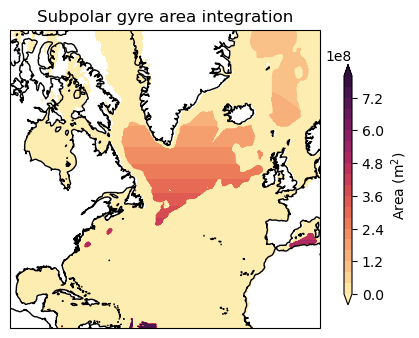

In [16]:
cutoff_contour = -10 ## in Sverdrups

projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), subplot_kw = {'projection': projection})

mask_neg10 = xr.where(Ψ_NA_tmean <= cutoff_contour, 1, 0)
area_subpolar = area_bu_NA * mask_neg10
p1 = axes.contourf(area_subpolar.xq, area_subpolar.yq, area_subpolar, levels = np.linspace(0, 8e8, 21), 
            cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both', color = 'black')

cax = plt.axes([0.96, 0.18, 0.02, 0.6])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Area (m$^2$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')
axes.set_title('Subpolar gyre area integration')

In [17]:
## One edge case remains, where the function encounters 3 alternating values, like 1, 0, 1.
## Another edge case is when the cutoff contour is close to zero.

def mask_interpolation_transect(Ψ, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type):

    ## This is the original mask
    new_mask = old_mask.copy(deep = True)

    ## We create a streamfunction transect with values greater/smaller than the cutoff transport
    if(gyre_type == 'subtropical'):
        Ψ_cutoff = Ψ.where(Ψ >=cutoff_contour).dropna('xq').load()
    elif(gyre_type == 'subpolar'):
        Ψ_cutoff = Ψ.where(Ψ <=cutoff_contour).dropna('xq').load()

    ## Checking if there are any values to interpolate (true for latitudes where the streamfunction is weaker than the cutoff for all longitudes)
    if(Ψ_cutoff.shape[0] == 0):  
        return old_mask, old_mask
    
    if(zero_precedes_one.shape[0] > 0):
        for i in zero_precedes_one:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)

    if(one_precedes_zero.shape[0] > 0):
        for i in one_precedes_zero:
            x_west = Ψ.xq[i]
            x_east = Ψ.xq[i+1]
            Ψ_east = Ψ.sel(xq = x_east, method = 'nearest').values
            Ψ_west = Ψ.sel(xq = x_west, method = 'nearest').values

            if (np.isnan(Ψ_west.item()) or np.isnan(Ψ_east.item())):
                continue

            slope = (Ψ_east - Ψ_west)/(x_east - x_west)
            x_mid = x_east - (Ψ_east - cutoff_contour)/slope
            mask_fraction = 1 - (x_east - x_mid)/(x_east - x_west)
            new_mask = xr.where(old_mask.xq == x_east, mask_fraction, new_mask)
        
    return old_mask, new_mask

def mask_with_interpolation(Ψ, old_mask_total, cutoff_contour, gyre_type, y_min_bound = None, y_max_bound = None):
           
    for y_sel in Ψ.yq.sel(yq = slice(y_min_bound, y_max_bound)).values:
        Ψ_ysel = Ψ.sel(yq = y_sel, method = 'nearest')
        old_mask = old_mask_total.sel(yq = y_sel, method = 'nearest')

        zero_precedes_one = np.where((old_mask.values[:-1] == 0) & (old_mask.values[1:] == 1))[0]
        one_precedes_zero = np.where((old_mask.values[:-1] == 1) & (old_mask.values[1:] == 0))[0]
        old_mask, new_mask = mask_interpolation_transect(Ψ_ysel, y_sel, zero_precedes_one, one_precedes_zero, cutoff_contour, old_mask, gyre_type)

        if(y_sel == Ψ.yq[0].item()):
            new_mask_total = new_mask
        else:
            new_mask_total = xr.concat([new_mask_total, new_mask], dim = 'yq')

    return new_mask_total

In [18]:
area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
area_bu = da_north_atlantic_mask_vmo(area_bu)
area_bu = area_bu.where(~np.isnan(vmo_2d_itp.isel(time = 0))).fillna(0)

def gyre_percentile_subpolar(expt_val, quantile, time_mean = True):
    umo_2d = cc.querying.getvar(expt_val, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_val, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    if(time_mean == True):
        Ψ_NA_tmean = Ψ_NA.mean('time')
    else:
        Ψ_NA_tmean = Ψ_NA.coarsen(time = 12).mean()
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar))
    Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})

    return Ψ_NA_tmean, Ψ_gyre

In [19]:
def gyre_percentile_subpolar_all_years(expt_val, quantile, time_mean = True):
    start_time = '2001-01-01'
    end_time = '2100-12-31'
    umo_2d = cc.querying.getvar(expt_val, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_val, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    if(time_mean == True):
        Ψ_NA_tmean = Ψ_NA.mean('time')
    else:
        Ψ_NA_tmean = Ψ_NA.coarsen(time = 12).mean()
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar))
    Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})

    return Ψ_NA_tmean, Ψ_gyre

In [20]:
var_list = ['beta_v', 'BPT', 'curl_NL', 'curl_taus', 'curl_taub', 'curl_diff', 'mass_flux', 'curl_dudt', 'eta_dt']

In [21]:
def find_last_one(arr):
    return np.array([np.max(np.where(row!=0)) if np.any(row!=0) else -1 for row in arr])
    
def masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved):

    data_np = mask_western_gyre_improved.values
    last_ones = find_last_one(mask_western_gyre_improved.values)
    updated_data_np = data_np.copy()
    updated_data_np2 = data_np.copy()
    for i, last_idx in enumerate(last_ones):
        if last_idx == -1:  # If there is at least one '1' in the row
            updated_data_np2[i, :] = 1
        else:
            updated_data_np[i, :last_idx] = 1
            updated_data_np2[i, :last_idx] = 0
            updated_data_np2[i, last_idx] = 1 - data_np[i, last_idx]
            updated_data_np2[i, last_idx + 1:] = 1

    mask_GS_west = xr.DataArray(updated_data_np, dims = ["yq", "xq"], coords = 
                                [mask_western_gyre_improved.yq, mask_western_gyre_improved.xq])
    mask_GS_east = xr.DataArray(updated_data_np2, dims = ["yq", "xq"], coords = 
                                [mask_western_gyre_improved.yq, mask_western_gyre_improved.xq])

    mask_GS_west = xr.where((mask_Ψ_improved + mask_GS_west) > 1, mask_Ψ_improved, 0)
    mask_GS_east = mask_Ψ_improved - mask_GS_west

    return mask_GS_west, mask_GS_east

0
1
2
3
4


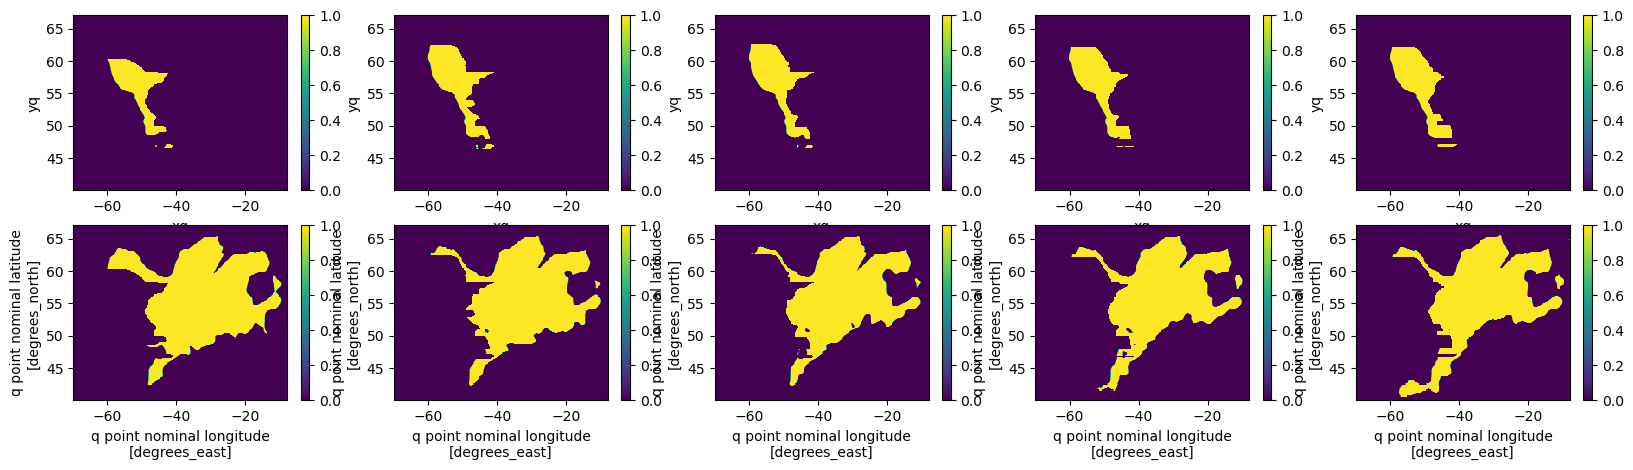

In [22]:
gyre_strength_comparison = np.zeros(5)

array_western = np.zeros((5, 10))
array_eastern = np.zeros((5, 10))

lat_boundary = -35
lat_separation_switch = True

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 5))

for j, expt_name in enumerate(dir_names):
    Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subpolar(expt[j], 0.05)
    Ψ_NA_tmean.load()
    Ψ_gyre_strength.load()
    file_path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Repeat-year-forcing-setup/Masks/Subpolar-streamfunctions/Post/' + str(j) + '.txt'
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        matrix = np.array([list(map(int, line.split())) for line in lines])
    
    mask_Ψ = xr.DataArray(matrix, coords = [Ψ_NA_tmean.yq, Ψ_NA_tmean.xq], dims = ['yq','xq'], name = 'mask', attrs = {'units':'none'})
    mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_contour, gyre_type = 'subpolar').load()
    if(lat_separation_switch == True):
        Ψ_NA_western = xr.where(Ψ_NA_tmean.xq < lat_boundary, Ψ_NA_tmean, 0)
        mask_western_gyre = xr.where(Ψ_NA_western <= Ψ_gyre_strength, 1, 0).load()
    else:
        mask_western_gyre = xr.where(Ψ_NA_tmean <= Ψ_gyre_strength, 1, 0).load()
    mask_western_gyre_improved = mask_with_interpolation(Ψ_NA_tmean, mask_western_gyre, Ψ_gyre_strength, gyre_type = 'subpolar').load()
    mask_interior_improved = (mask_Ψ_improved - mask_western_gyre_improved)
    western_mask_subpolar, eastern_mask_subpolar = masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved)

    western_mask_subpolar.plot(ax = axes[0][j])
    eastern_mask_subpolar.plot(ax = axes[1][j])
    gyre_strength_comparison[j] = Ψ_gyre_strength
    vort_BPT = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc').BPT.sel(time = slice(start_time, end_time))

    β = 2 * Ω * np.cos(geolat_c * np.pi /180.)/R_earth
    β = (xr.where(western_mask_subpolar == 0, np.nan, 1) * β).mean('xq')

    bvb_ds = xr.open_dataset(base_dir + dir_names[j] + '/bvb.nc').sel(time = slice(start_time, end_time))
    temp_western = np.zeros(9)
    temp_eastern = np.zeros(9)
    print(j)
    for i, var_name in enumerate(var_list):
        var = bvb_ds[var_name]
        var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
        var = (var * eastern_mask_subpolar * area_bu_NA).sum('xq').sum('yq').mean('time')
        var = var/(β * dyCv).sum('yq')/1e6
        temp_eastern[i] = var.values
    
        var = bvb_ds[var_name]
        var = xr.where(np.isnan(vort_BPT.isel(time = 0)), np.nan, var)
        var = (var * western_mask_subpolar * area_bu_NA).sum('xq').sum('yq').mean('time')
        var = var/(β * dyCv).sum('yq')/1e6
        temp_western[i] = var.values
        
    array_western[j, 0:9] = temp_western
    array_eastern[j, 0:9] = temp_eastern
    array_western[j, 9] = abs(Ψ_gyre_strength.values) - abs(np.sum(temp_western[1:])) - abs(cutoff_contour)
    array_eastern[j, 9] = abs(Ψ_gyre_strength.values) - abs(np.sum(temp_eastern[1:])) - abs(cutoff_contour)

## Plotting in two parts

In [1]:
def percentiles(expt_name, steps = 101):
    area_bu = cc.querying.getvar(expt[2], 'areacello_bu', session, frequency = 'static', n = 1)
    area_bu = da_north_atlantic_mask_vmo(area_bu)

    umo_2d = cc.querying.getvar(expt_name, 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = cc.querying.getvar(expt_name, 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                                end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    
    grid_data = xr.merge((umo_2d, vmo_2d))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = da_north_atlantic_mask_vmo(vmo_2d_itp)
    
    area_bu = area_bu.where(~np.isnan(vmo_2d_itp.isel(time = 0))).fillna(0)
    
    Ψ_NA = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
    if(time_mean == True):
        Ψ_NA_tmean = Ψ_NA.mean('time')
    else:
        Ψ_NA_tmean = Ψ_NA.coarsen(time = 12).mean()
    Ψ_NA_tmean = Ψ_NA_tmean.chunk(chunks = {'xq':-1, 'yq':-1})
    Ψ_NA_tmean = -1 * Ψ_NA_tmean.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).load()
    area_bu_NA = area_bu.sel(xq = slice(x_min_subpolar, x_max_subpolar)).sel(yq = slice(y_min_subpolar, y_max_subpolar)).load()

    Ψ_gyre_all = np.zeros(steps)
    for i in range(steps):
        quantile = 1/(steps - 1) * i
        Ψ_gyre = Ψ_NA_tmean.weighted(area_bu).quantile(quantile, dim = {"yq", "xq"})
        Ψ_gyre_all[i] = Ψ_gyre.values

    return Ψ_gyre_all

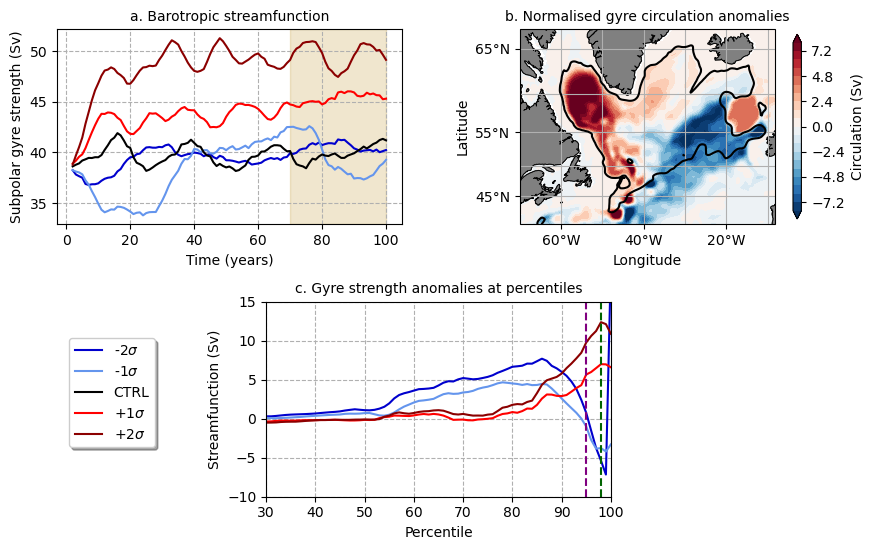

In [23]:
fig = plt.figure()
fig.set_figheight(4 * 1.4)
fig.set_figwidth(6 * 1.4)

ax1 = plt.subplot2grid(shape = (2, 4), loc = (0, 0), rowspan = 1, colspan = 2)

## A. Gyre strength

for j, expt_name in enumerate(dir_names):
    Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subpolar_all_years(expt[j], 0.05, time_mean = False)
    ax1.plot(np.linspace(1, 100, 100), -1 * Ψ_gyre_strength.rolling(time = 5, min_periods = 2).mean().values, color = color_values[j], 
                 label = expt_labels[j])
ax1.set_title('a. Barotropic streamfunction', fontsize = 10)
ax1.set_ylabel('Subpolar gyre strength (Sv)')
ax1.set_xlabel('Time (years)')
#ax1.legend()
ax1.axvspan(xmin = 70, xmax = 100, alpha = 0.2, color = 'darkgoldenrod')
ax1.grid(True, ls = '--')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, expt_labels, loc = 'lower left', bbox_to_anchor = (0.08, 0.18),
          fancybox = True, shadow = True, ncol = 1, fontsize = 10)

## B. Anomalies in gyre circulation

my_xticks = [-60, -40, -20]
my_yticks = [45, 55, 65]

projection = ccrs.Mercator(central_longitude = (x_max_subpolar + x_min_subpolar)/2, min_latitude = y_min_subpolar, 
                           max_latitude = y_max_subpolar)

ax1 = plt.subplot2grid(shape = (2, 4), loc = (0, 2), rowspan = 1, colspan = 2, projection = projection)

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor='gray', linewidth = 0.5)
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

a = -psi_subpolar.time
b = psi_subpolar
d = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

p1 = ax1.contourf(psi_subpolar.xh, psi_subpolar.yh, d, levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
ax1.contour(psi_subpolar.xh, psi_subpolar.yh, psi_subpolar.rename('Circulation (Sv)')[2], levels = [-10], cmap = 'Greys_r', 
                transform = ccrs.PlateCarree(), extend = 'both')

ax1.set_yticks(my_yticks, crs = ccrs.PlateCarree())
ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())
ax1.set_ylabel('Latitude', fontsize = 10)

ax1.set_xticks(my_xticks, crs = ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax1.set_xlabel('Longitude', fontsize = 10)


cax = plt.axes([0.95, 0.6, 0.01, 0.33])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Circulation (Sv)', fontsize = 10)

ax1.set_title('b. Normalised gyre circulation anomalies', fontsize = 10)

## C. Percentiles for each case

time_mean = True
ax1 = plt.subplot2grid(shape = (2, 4), loc = (1, 1), rowspan = 1, colspan = 2)

steps = 101
Ψ_gyre_all_CTRL = percentiles(expt[2], steps)
for j in range(5):
    if(j!=2):
        Ψ_gyre_all = percentiles(expt[j], steps = 101)
        Ψ_gyre_all_anomaly = Ψ_gyre_all - Ψ_gyre_all_CTRL
        ax1.plot(np.linspace(0, steps - 1, steps), Ψ_gyre_all_anomaly, color = color_values[j], label = expt_labels[j])

ax1.set_xlabel('Percentile', fontsize = 10)
ax1.set_ylabel('Streamfunction (Sv)', fontsize = 10)
#ax1.legend()
ax1.grid(ls = '--')
ax1.set_xlim([30, 100])
ax1.set_ylim([-10, 15])
ax1.set_title('c. Gyre strength anomalies at percentiles', fontsize = 10)
ax1.axvline(95, color = 'purple', ls = '--')
ax1.axvline(98, color = 'darkgreen', ls = '--')

ax1.legend().set_visible(False)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Subpolar-gyre-perturbations-intro-revised.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

In [23]:
def potrho_expt_depth(expt_val, start_time_val, end_time_val):
    salt = cc.querying.getvar(expt_val, 'so', session, frequency = '1 monthly', start_time = start_time_val, 
                            end_time = end_time_val, chunks = {}).sel(time = slice(start_time_val, end_time_val))
    salt = salt.coarsen(time = 12).mean()
    area = cc.querying.getvar(expt[2], 'areacello', session, frequency = 'static', n = 1)
    pressure = xr.DataArray(p_from_z(depth_tile, geolat), coords = [salt.yh, salt.xh], dims = ['yh', 'xh'], 
                        name = 'pressure', attrs = {'units':'dbar'})
    salt = xr.DataArray(SA_from_SP(salt, pressure, salt.xh, salt.yh), 
                        coords = [salt.time, salt.z_l, salt.yh, salt.xh], dims = ['time', 'z_l', 'yh', 'xh'], 
                        name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    area = area * (salt[0]/salt[0])
    temp = cc.querying.getvar(expt_val, 'thetao', session, frequency = '1 monthly', start_time = start_time_val, 
                            end_time = end_time_val, chunks = {}).sel(time = slice(start_time_val, end_time_val))
    temp = temp.coarsen(time = 12).mean()
    potrho_2 = xr.DataArray(rho(salt, temp, pressure), coords = [salt.time, salt.z_l, salt.yh, salt.xh], 
                            dims = ['time', 'z_l', 'yh', 'xh'], name = 'potential density ref 2000dbar', 
                            attrs = {'units':'kg/m^3 (-2000 kg/m^3)'})
    return potrho_2, area

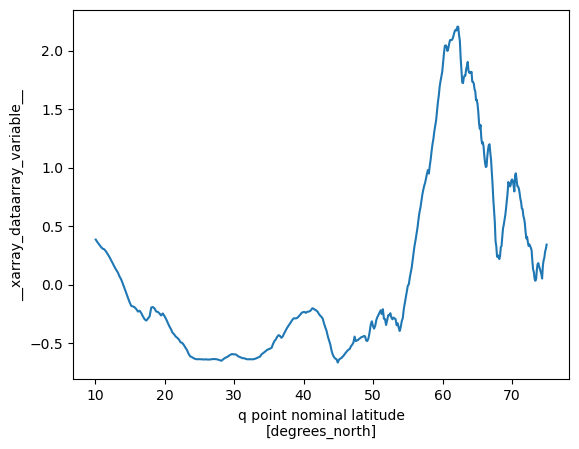

In [35]:
mean_curl_taus.plot()

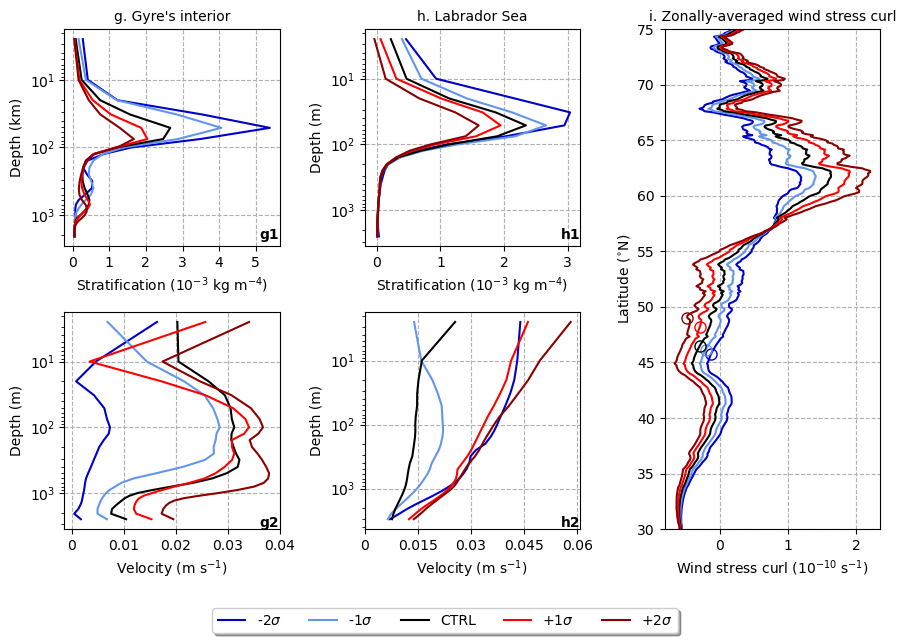

In [36]:
## C. Ekman transport

fig = plt.figure()
fig.set_figheight(4 * 1.5)
fig.set_figwidth(6 * 1.5)

x_lab, y_lab = -55, 60
x_east, y_east = -27, 56

ax1 = plt.subplot2grid(shape = (2, 3), loc = (0, 2), rowspan = 2, colspan = 1)

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

for i, j in enumerate(expt):
    curl_taus1 = xr.open_dataset(base_dir + dir_names[i] + '/141-180/curl_taus_filtered2.nc')['__xarray_dataarray_variable__'].sel(filter_scale = 5).sel(time = slice(start_time, end_time))
    curl_taus2 = xr.open_dataset(base_dir + dir_names[i] + '/181-200/curl_taus_filtered.nc')['__xarray_dataarray_variable__'].sel(filter_scale = 5).sel(time = slice(start_time, end_time))
    curl_taus = xr.concat([curl_taus1, curl_taus2], dim = 'time').mean('time')
    curl_taus = curl_taus.sel(yq = slice(y_min, y_max)).sel(xq = slice(x_min, x_max))
    mean_curl_taus = (curl_taus.mean('xq')/1e-10).load()
    mean_curl_taus.plot(color = color_values[i], label = expt_labels[i], ax = ax1, y = 'yq')#, lw = 0.75)

    vmo_2d = cc.querying.getvar(expt[i], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d = vmo_2d.sel(xh = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    Ψ = vmo_2d.cumsum('xh')/(1e6 * ρ0)
    Ψ = Ψ.mean('time').sel(yq = slice(40, 50))
    
    NAC = xr.where(Ψ.sel(xh = -30, method = 'nearest').sel(yq = slice(40, 50)) >=0, 1, np.nan)
    NAC_lat = NAC.dropna(dim = 'yq').yq[-1]
    NAC_value = mean_curl_taus.sel(yq = NAC_lat, method = 'nearest')

    ax1.plot(NAC_value, NAC_lat, marker = 'o', color = color_values[i], markersize = 8, markerfacecolor='none')

ax1.grid(True, ls = '--')
ax1.set_title('i. Zonally-averaged wind stress curl', fontsize = 10)
ax1.set_xlabel('Wind stress curl (10$^{-10}$ s$^{-1}$)')
ax1.set_ylabel('Latitude ($^{\circ}$N)')
ax1.set_ylim([30, 75])
#ax1.set_ylim([35, 65])

## D1. Stratification - Labrador Sea

ax_lab1  = plt.subplot2grid(shape = (2, 3), loc = (0, 1), rowspan = 1, colspan = 1)
ax_lab2  = plt.subplot2grid(shape = (2, 3), loc = (1, 1), rowspan = 1, colspan = 1)
ax_east1 = plt.subplot2grid(shape = (2, 3), loc = (0, 0), rowspan = 1, colspan = 1)
ax_east2 = plt.subplot2grid(shape = (2, 3), loc = (1, 0), rowspan = 1, colspan = 1)

z_l = cc.querying.getvar(expt[2], 'z_l', session, n = 1)
geolat = cc.querying.getvar(expt[2], 'geolat', session, n = 1)
depth_tile = (geolat * 0 + 1) * -1 * z_l[0].values

for i, expt_name in enumerate(dir_names):

    ## 1. Stratification
    potrho_2, area = potrho_expt_depth(expt[i], start_time, end_time)
    
    potrho_2_lab = potrho_2.sel(xh = x_lab, method = 'nearest').sel(yh = y_lab, method = 'nearest')
    potrho_2_lab = potrho_2_lab.mean('time')
    potrho_2_lab.differentiate('z_l').plot(ax = ax_lab1, y = 'z_l', color = color_values[i], label = expt_labels[i])

    potrho_2_east = potrho_2.sel(xh = x_east, method = 'nearest').sel(yh = y_east, method = 'nearest')
    potrho_2_east = potrho_2_east.mean('time')
    potrho_2_east.differentiate('z_l').plot(y = 'z_l', ax = ax_east1, label = expt_labels[i], color = color_values[i])

    ## 2. Velocity
    ty_trans = cc.querying.getvar(expt[i], 'vo', session, frequency = '1 monthly', start_time = start_time, end_time = end_time, 
                                  chunks = {}).sel(time = slice(start_time, end_time)).isel(yq = slice(1, None)).mean('time')
    tx_trans = cc.querying.getvar(expt[i], 'uo', session, frequency = '1 monthly', start_time = start_time, end_time = end_time, 
                                  chunks = {}).sel(time = slice(start_time, end_time)).isel(xq = slice(1, None)).mean('time')

    grid_data = xr.merge((tx_trans, ty_trans))
    grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])
    ty_trans_itp = grid.interp(ty_trans, 'Y', boundary = 'fill')
    tx_trans_itp = grid.interp(tx_trans, 'X', boundary = 'fill')

    ty_trans_lab  = ty_trans_itp. sel(xh = x_lab, method = 'nearest'). sel(yh = y_lab, method = 'nearest')
    ty_trans_east = ty_trans_itp.sel(xh = x_east, method = 'nearest').sel(yh = y_east, method = 'nearest')
    tx_trans_lab  = tx_trans_itp. sel(xh = x_lab, method = 'nearest'). sel(yh = y_lab, method = 'nearest')
    tx_trans_east = tx_trans_itp.sel(xh = x_east, method = 'nearest').sel(yh = y_east, method = 'nearest')
    
    flow_lab  = (ty_trans_lab **2 + tx_trans_lab **2)**(0.5)
    flow_east = (ty_trans_east**2 + tx_trans_east**2)**(0.5)
    
    flow_lab .plot(y = 'z_l', ax = ax_lab2 , color = color_values[i])
    flow_east.plot(y = 'z_l', ax = ax_east2, color = color_values[i])

ax_lab1.invert_yaxis()    
ax_lab1.set_title('h. Labrador Sea', fontsize = 10)
ax_lab1.set_ylabel('Depth (m)', fontsize = 10)
ax_lab1.set_xlabel('Stratification (10$^{-3}$ kg m$^{-4}$)', fontsize = 10)
ax_lab1.grid(True, ls = '--')
ax_lab1.set_yscale('log')
ax_lab1.set_xticks([0, 1e-3, 2e-3, 3e-3])
ax_lab1.set_xticklabels([0, 1, 2, 3])

ax_east1.invert_yaxis()
ax_east1.set_title("g. Gyre's interior", fontsize = 10)
ax_east1.set_ylabel('Depth (km)', fontsize = 10)
ax_east1.set_xlabel('Stratification (10$^{-3}$ kg m$^{-4}$)', fontsize = 10)
ax_east1.grid(True, ls = '--')
ax_east1.set_yscale('log')
ax_east1.set_xticks([0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3])
ax_east1.set_xticklabels([0, 1, 2, 3, 4, 5])

ax_lab2.invert_yaxis()    
ax_lab2.set_title('', fontsize = 10)
ax_lab2.set_ylabel('Depth (m)', fontsize = 10)
ax_lab2.set_xlabel('Velocity (m s$^{-1}$)', fontsize = 10)
ax_lab2.grid(True, ls = '--')
ax_lab2.set_yscale('log')
ax_lab2.set_xticks([0, 0.015, 0.03, 0.045, 0.06])
ax_lab2.set_xticklabels([0, 0.015, 0.03, 0.045, 0.06])

ax_east2.invert_yaxis()    
ax_east2.set_title('', fontsize = 10)
ax_east2.set_ylabel('Depth (m)', fontsize = 10)
ax_east2.set_xlabel('Velocity (m s$^{-1}$)', fontsize = 10)
ax_east2.grid(True, ls = '--')
ax_east2.set_yscale('log')
ax_east2.set_xticks([0, 0.01, 0.02, 0.03, 0.04])
ax_east2.set_xticklabels([0, 0.01, 0.02, 0.03, 0.04])

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox = True, shadow = True, ncol = 5, fontsize = 10)

fig.text(0.305, 0.6, 'g1', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 10, fontweight = 'bold')
fig.text(0.64, 0.6, 'h1', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 10, fontweight = 'bold')
fig.text(0.64, 0.12, 'h2', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 10, fontweight = 'bold')
fig.text(0.305, 0.12, 'g2', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 10, fontweight = 'bold')

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Subpolar-gyre-stress-density-profiles-revised.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

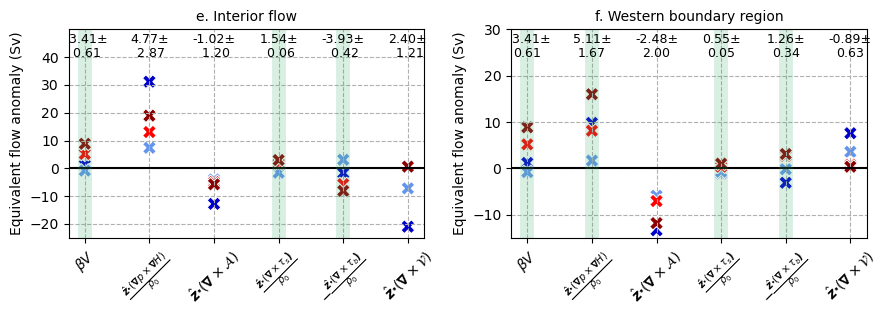

In [33]:
## B. Gyre's western boundary

fig = plt.figure()
fig.set_figheight(2.2 * 1.5)
fig.set_figwidth(6 * 1.5)

ax1 = plt.subplot2grid(shape = (1, 2), loc = (0, 1), rowspan = 1, colspan = 1)

expt_labels = ['-2$\sigma$', '-1$\sigma$', 'CTRL', '+1$\sigma$', '+2$\sigma$']

# Define significance threshold
p_value_threshold = 0.1

# Define custom colors for each experiment
custom_palette = {
    expt_labels[0]: color_values[0],
    expt_labels[1]: color_values[1],
    expt_labels[2]: color_values[2],
    expt_labels[3]: color_values[3],
    expt_labels[4]: color_values[4],
}
array_western_difference = array_western - array_western[2, :]

WBC_subpolar = {
    'Experiment': expt_labels,
    r'$\beta V$': list(-array_western[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(-array_western[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(-array_western[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(-array_western[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(-array_western[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(-array_western[:, 5])
}

WBC_subpolar_difference = {
    'Experiment': expt_labels,
    r'$\beta V$': list(-array_western_difference[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(-array_western_difference[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(-array_western_difference[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(-array_western_difference[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(-array_western_difference[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(-array_western_difference[:, 5])
}

# Convert to DataFrame
WBC_subpolar = pd.DataFrame(WBC_subpolar)
WBC_subpolar_difference = pd.DataFrame(WBC_subpolar_difference)
WBC_subpolar_difference = WBC_subpolar_difference[WBC_subpolar_difference["Experiment"] != "CTRL"]

# Reshape the data for easier plotting with scatter points
WBC_melted = pd.melt(WBC_subpolar_difference, id_vars = ['Experiment'], var_name = 'Vorticity term', value_name = 'Equivalent flow (Sv)')

# Assign numerical indices to experiments
experiment_indices = np.array([-2, -1, 0, 1, 2])

# Create the scatter plot with points instead of lines
sns.scatterplot(data = WBC_melted, x = 'Vorticity term', y = 'Equivalent flow (Sv)', hue = 'Experiment', palette=custom_palette, 
                style = 'Experiment', s = 100, markers=['X']*5, color = color_values, ax = ax1, legend = False)
ax1.set_title('f. Western boundary region', fontsize = 10)
ax1.set_xlabel('')
ax1.set_ylabel('Equivalent flow anomaly (Sv)')
ax1.grid(True, ls = '--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax1.axhline(0, color = 'black')
ax1.set_ylim([-15, 30])

exclude_index = ['-2']  # Replace with the index you want to remove
results = {}

# Convert experiment_indices to a NumPy array if it isn't already
experiment_indices = np.array(experiment_indices)

# Perform linear regression for each variable and calculate p-value
for j, variable in enumerate(WBC_melted['Vorticity term'].unique()):
    y_values = WBC_subpolar[variable].values
    x_values = experiment_indices
    
    # Create a mask to exclude the specific experiment index
    #mask = ~np.isin(x_values, exclude_index)
    mask = [False, True, True, True, True]
    
    # Filter y_values and x_values based on the mask
    y_values_filtered = y_values[mask]
    x_values_filtered = sm.add_constant(x_values[mask])

    # Finding p_value, standard error, and linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values_filtered[:,1], y_values_filtered)
    
    ## Fit the linear model
    #model = sm.OLS(y_values_filtered, x_values_filtered).fit()
    
    ## Store the slope and p-value
    #slope = model.params[1]
    #p_value = model.pvalues[1]
    #results[variable] = (slope, p_value)
    
    if p_value < p_value_threshold:
        ax1.axvline(j, color='mediumseagreen', alpha=0.2, linewidth=10)
    #elif p_value < p_value_threshold * 2:
    #    ax1.axvline(j, color='darkgoldenrod', alpha=0.2, linewidth=10)

    if(j == 0):
        ax1.text(j, 27, '  ' + f"{slope:.2f}" + '±', ha='center', fontsize = 9)
    else:
        ax1.text(j, 27, f"{slope:.2f}" + '±', ha='center', fontsize = 9)
    ax1.text(j, 24, '' + f"{std_err:.2f}", ha='center', fontsize = 9)

## A: Gyre's interior

ax1 = plt.subplot2grid(shape = (1, 2), loc = (0, 0), rowspan = 1, colspan = 1)

array_eastern_difference = array_eastern - array_eastern[2, :]

interior_subpolar = {
    'Experiment': expt_labels,
    r'$\beta V$': list(array_eastern[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(array_eastern[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(array_eastern[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(array_eastern[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(array_eastern[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(array_eastern[:, 5])
}

interior_subpolar_difference = {
    'Experiment': expt_labels,
    r'$\beta V$': list(array_eastern_difference[:, 0]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} p \times \boldsymbol{\nabla} H)}{\rho_0}$': list(array_eastern_difference[:, 1]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{A}})$': list(array_eastern_difference[:, 2]),
    r'$\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_s)}}{\rho_0}$': list(array_eastern_difference[:, 3]),
    r'$-\frac{\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\tau_b)}}{\rho_0}$': list(array_eastern_difference[:, 4]),
    r'$\hat{\boldsymbol{z}} \boldsymbol{\cdot} (\boldsymbol{\nabla} \times \boldsymbol{\mathcal{V}})$': list(array_eastern_difference[:, 5])
}

# Convert to DataFrame
interior_subpolar = pd.DataFrame(interior_subpolar)
interior_subpolar_difference = pd.DataFrame(interior_subpolar_difference)
interior_subpolar_difference = interior_subpolar_difference[interior_subpolar_difference["Experiment"] != "CTRL"]

# Reshape the data for easier plotting with scatter points
interior_melted = pd.melt(interior_subpolar_difference, id_vars = ['Experiment'], var_name = 'Vorticity term', value_name = 'Equivalent flow (Sv)')

# Assign numerical indices to experiments
experiment_indices = np.array([-2, -1, 0, 1, 2])

# Create the scatter plot with points instead of lines
sns.scatterplot(data = interior_melted, x = 'Vorticity term', y = 'Equivalent flow (Sv)', hue = 'Experiment', palette=custom_palette, 
                style = 'Experiment', s = 100, markers=['X']*5, color = color_values, ax = ax1, legend = False)
ax1.set_title('e. Interior flow', fontsize = 10)
ax1.set_xlabel('')
ax1.set_ylabel('Equivalent flow anomaly (Sv)')
ax1.grid(True, ls = '--')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax1.axhline(0, color = 'black')
ax1.set_ylim([-25, 50])

exclude_index = ['-2']  # Replace with the index you want to remove
results = {}

# Convert experiment_indices to a NumPy array if it isn't already
experiment_indices = np.array(experiment_indices)

# Perform linear regression for each variable and calculate p-value
for j, variable in enumerate(interior_melted['Vorticity term'].unique()):
    y_values = interior_subpolar[variable].values
    x_values = experiment_indices
    
    # Create a mask to exclude the specific experiment index
    #mask = ~np.isin(x_values, exclude_index)
    mask = [False, True, True, True, True]
    
    # Filter y_values and x_values based on the mask
    y_values_filtered = y_values[mask]
    x_values_filtered = sm.add_constant(x_values[mask])

    # Finding p_value, standard error, and linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values_filtered[:,1], y_values_filtered)
    
    ## Fit the linear model
    #model = sm.OLS(y_values_filtered, x_values_filtered).fit()
    
    ## Store the slope and p-value
    #slope = model.params[1]
    #p_value = model.pvalues[1]
    #results[variable] = (slope, p_value)
    
    if p_value < p_value_threshold:
        ax1.axvline(j, color='mediumseagreen', alpha = 0.2, linewidth=10)
    #elif p_value < p_value_threshold * 2:
    #    ax1.axvline(j, color='darkgoldenrod', alpha=0.2, linewidth=10)

    if(j == 0):
        ax1.text(j, 45, '  ' + f"{slope:.2f}" + '±', ha = 'center', fontsize = 9)
    else:
        ax1.text(j, 45, f"{slope:.2f}" + '±', ha = 'center', fontsize = 9)
    ax1.text(j, 40, ' ' + f"{std_err:.2f}", ha = 'center', fontsize = 9)
    ax1.set_yticks([-20, -10, 0, 10, 20, 30, 40, 50])

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Subpolar-gyre-perturbations-regressions-revised.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)

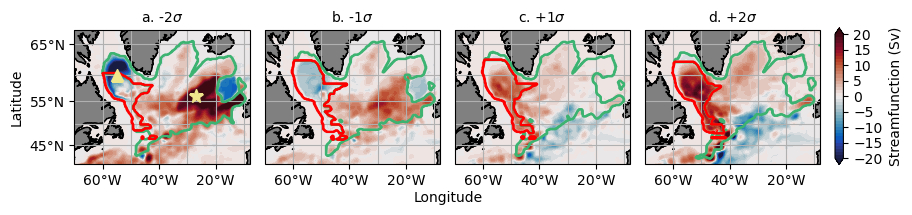

In [28]:
## C-F. Flow anomalies

projection = ccrs.Mercator(central_longitude = (x_max_subpolar + x_min_subpolar)/2, min_latitude = y_min_subpolar, max_latitude = y_max_subpolar)
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (6 * 1.4, 1.5 * 1.4), subplot_kw = {'projection': projection})

expt_labels = ['-2$\sigma$', '-1$\sigma$', '+1$\sigma$', '+2$\sigma$']
alpha_labels = ['a. ', 'b. ', 'c. ', 'd. ']
x_min_subpolar, x_max_subpolar = -70, -8
y_min_subpolar, y_max_subpolar = 40, 67

dir_names_anomalies = ['Monthly_mean_BVB_MOM6-SIS2_negativeNAO-2.0', 
                       'Monthly_mean_BVB_MOM6-SIS2_negativeNAO-1.0', 
                       'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-1.0',
                       'Monthly_mean_BVB_MOM6-SIS2_positiveNAO-2.0']

expt_anomalies = ['mom6-om4-025-RYF-negativeNAO-2.0', 
                  'mom6-om4-025-RYF-negativeNAO-1.0', 
                  'mom6-om4-025-RYF-positiveNAO-1.0',
                  'mom6-om4-025-RYF-positiveNAO-2.0']

my_xticks = [-60, -40, -20]
my_yticks = [45, 55, 65]

## Step 1: Find the control barotropic streammfunction
vmo_2d = cc.querying.getvar(expt[2], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
umo_2d = cc.querying.getvar(expt[2], 'umo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(xq = slice(1, None)).sel(time = slice(start_time, end_time))

grid_data = xr.merge((umo_2d, vmo_2d))
grid = xgcm.Grid(grid_data, coords={'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
vmo_2d_NA = vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
Ψ = vmo_2d_NA.cumsum('xq')/(1e6 * ρ0)
Ψ_CTRL = Ψ.mean('time').load()

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor='gray', linewidth = 0.5)

for i, expt_name in enumerate(dir_names_anomalies):

    ## Step 2: Find the perturbation experiment barotropic streamfunction
    vmo_2d = cc.querying.getvar(expt_anomalies[i], 'vmo_2d', session, frequency = '1 monthly', start_time = start_time, 
                            end_time = end_time, chunks = {}).isel(yq = slice(1, None)).sel(time = slice(start_time, end_time))
    vmo_2d_itp = grid.interp(vmo_2d, 'X', boundary = 'fill')
    vmo_2d_NA = vmo_2d_itp.sel(xq = slice(x_min, x_max)).sel(yq = slice(y_min, y_max))
    Ψ = vmo_2d_NA.cumsum('xq').mean('time')/(1e6 * ρ0)

    ## Step 3: Find the difference
    Ψ_anomaly = (Ψ - Ψ_CTRL).load()

    ## Step 4: Find western and eastern region masks
    Ψ_NA_tmean, Ψ_gyre_strength = gyre_percentile_subpolar(expt[i], 0.05)
    Ψ_NA_tmean.load()
    Ψ_gyre_strength.load()
    
    file_path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Repeat-year-forcing-setup/Masks/Subpolar-streamfunctions/Post/' + str(i) + '.txt'
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        matrix = np.array([list(map(int, line.split())) for line in lines])
    
    mask_Ψ = xr.DataArray(matrix, coords = [Ψ_NA_tmean.yq, Ψ_NA_tmean.xq], dims = ['yq','xq'], name = 'mask', attrs = {'units':'none'})
    mask_Ψ_improved = mask_with_interpolation(Ψ_NA_tmean, mask_Ψ, cutoff_contour, gyre_type = 'subpolar').load()
    if(lat_separation_switch == True):
        Ψ_NA_western = xr.where(Ψ_NA_tmean.xq < lat_boundary, Ψ_NA_tmean, 0)
        mask_western_gyre = xr.where(Ψ_NA_western <= Ψ_gyre_strength, 1, 0).load()
    else:
        mask_western_gyre = xr.where(Ψ_NA_tmean <= Ψ_gyre_strength, 1, 0).load()
    mask_western_gyre_improved = mask_with_interpolation(Ψ_NA_tmean, mask_western_gyre, Ψ_gyre_strength, gyre_type = 'subpolar').load()
    mask_interior_improved = (mask_Ψ_improved - mask_western_gyre_improved)
    western_mask_subpolar, eastern_mask_subpolar = masks_separation_gyre_strength(mask_western_gyre_improved, mask_Ψ_improved)

    p1 = axes[i].contourf(Ψ_anomaly.xq, Ψ_anomaly.yq, -Ψ_anomaly, levels = np.linspace(-20, 20, 41), 
                     cmap = cm.cm.balance, transform = ccrs.PlateCarree(), extend = 'both')

    axes[i].coastlines(resolution = '50m')
    axes[i].add_feature(land_50m)
    gl = axes[i].gridlines(draw_labels = False)

    axes[i].contour(eastern_mask_subpolar.xq, eastern_mask_subpolar.yq, eastern_mask_subpolar, levels = 1, colors = 'mediumseagreen', transform = ccrs.PlateCarree(), lw = 1, linestyles = '-')
    axes[i].contour(western_mask_subpolar.xq, western_mask_subpolar.yq, western_mask_subpolar, levels = 1, colors = 'Red', transform = ccrs.PlateCarree(), lw = 1, linestyles = '-')

    axes[i].set_extent([x_min_subpolar, x_max_subpolar, y_min_subpolar, y_max_subpolar], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title(alpha_labels[i] + expt_labels[i], fontsize = 10)
    
    axes[i].set_xticks(my_xticks, crs = ccrs.PlateCarree())
    axes[i].xaxis.set_major_formatter(cticker.LongitudeFormatter())
    axes[i].set_xlabel('')

axes[0].set_yticks(my_yticks, crs = ccrs.PlateCarree())
axes[0].yaxis.set_major_formatter(cticker.LatitudeFormatter())
axes[0].set_ylabel('Latitude')

axes[0].plot(x_lab, y_lab, marker = '^', color = 'khaki', markersize = 8, transform = ccrs.PlateCarree())
axes[0].plot(x_east, y_east, marker = '*', color = 'khaki', markersize = 10, transform = ccrs.PlateCarree())

fig.text(0.54, 0.02, 'Longitude', va = 'center', ha = 'center', rotation = 'horizontal', fontsize = 10)

cax = plt.axes([1, 0.18, 0.01, 0.65])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Streamfunction (Sv)', fontsize = 10)

fig.tight_layout()

plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Draft_figures/Subpolar-gyre-perturbations-masks-revised.pdf', bbox_inches = 'tight', 
            dpi = 300, transparent=True)